## Global Segmentación semántica

In [1]:
import kagglehub # Biblioteca para descargar dataset
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils import data
import os
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import kagglehub
from torch.utils.data import random_split, DataLoader


# Descarga del Dataset

Descargo el dataset desde Kaggle

In [2]:

# Download latest version
path = kagglehub.dataset_download("nikhilroxtomar/brain-tumor-segmentation")

print("Path to dataset files:", path)


100%|██████████| 312M/312M [00:03<00:00, 108MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nikhilroxtomar/brain-tumor-segmentation/versions/1


Defino la clase BrainTumorDataset que incluye el procesamiento de las imágenes y las máscaras del dataset.

In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, images_path, masks_path, transform, images_size):
        self.images_path = images_path
        self.masks_path = masks_path
        self.image_files = os.listdir(images_path)
        self.mask_files = os.listdir(masks_path)
        self.transform = transform
        self.images_size = images_size

        # Cargar todas las imágenes y máscaras en memoria
        self.images = [self.load_image(os.path.join(images_path, file)) for file in self.image_files]
        self.masks = [self.load_mask(os.path.join(masks_path, file)) for file in self.mask_files]

        assert len(self.images) == len(self.masks), "Número de imágenes y máscaras no son iguales"

    def load_image(self, path):
        image = Image.open(path).convert("RGB")
        image = image.resize(self.images_size)
        return self.transform(image)

    def load_mask(self, path):
        mask = Image.open(path).convert("L")
        mask = mask.resize(self.images_size)
        mask = np.array(mask) # Array numpy
        # Aplico un umbral
        umbral = 200
        mask = (mask >= umbral).astype(np.uint8)  # 1 para valores >= umbral (TUMOR), 0 en otro caso (FONDO)
        mask = torch.tensor(mask, dtype=torch.long)  # Convierto a tensor de tipo Long
        mask.unsqueeze_(0)  # Agrego una dimensión de canal
        return mask

    def unique_values(self, i):
        print("Unique values", torch.unique(self.masks[i]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        return self.images[i], self.masks[i]

    def display_images_masks(self, i):
      fig, axs = plt.subplots(1, 2, figsize=(10, 5))
      axs[0].imshow(self.images[i].permute(1, 2, 0))
      axs[0].set_title('Imagen')
      axs[1].imshow(self.masks[i].squeeze(), cmap='gray')
      axs[1].set_title('Máscara')
      plt.show()

In [4]:
image_path = os.path.join(path, "images")
mask_path = os.path.join(path, "masks")
print(image_path)
print(mask_path)


BTdataset = BrainTumorDataset(image_path, mask_path, transforms.ToTensor(), (224, 224))

/root/.cache/kagglehub/datasets/nikhilroxtomar/brain-tumor-segmentation/versions/1/images
/root/.cache/kagglehub/datasets/nikhilroxtomar/brain-tumor-segmentation/versions/1/masks


Verifico el tamaño de dataset y la forma que tienen las imágenes y las máscaras.
Además *unique values* verifica que la máscara solo tenga dos valores: 0 y 1.
- 0 corresponde a los píxeles que son **fondo**
- 1 corresponde a los píxeles que son **tumor**

In [5]:
print("Tamaño del dataset BTdataset", len(BTdataset))
print("BTDataset")
print(BTdataset[0][0].shape)
print(BTdataset[0][1].shape)
BTdataset.unique_values(0)
BTdataset.unique_values(1)

Tamaño del dataset BTdataset 3064
BTDataset
torch.Size([3, 224, 224])
torch.Size([1, 224, 224])
Unique values tensor([0, 1])
Unique values tensor([0, 1])


BTDataset


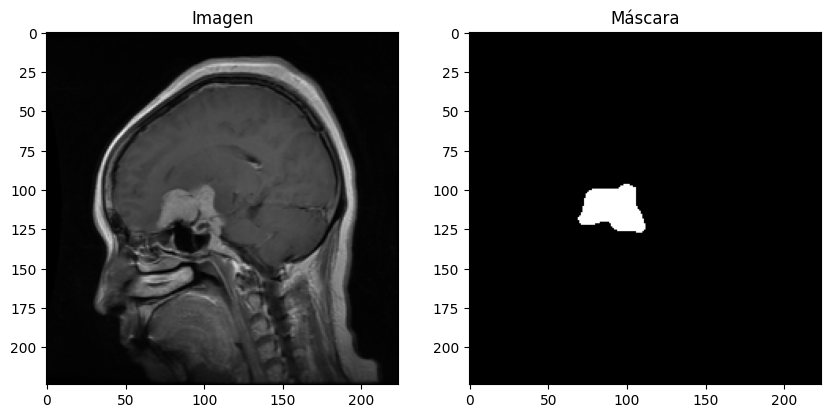

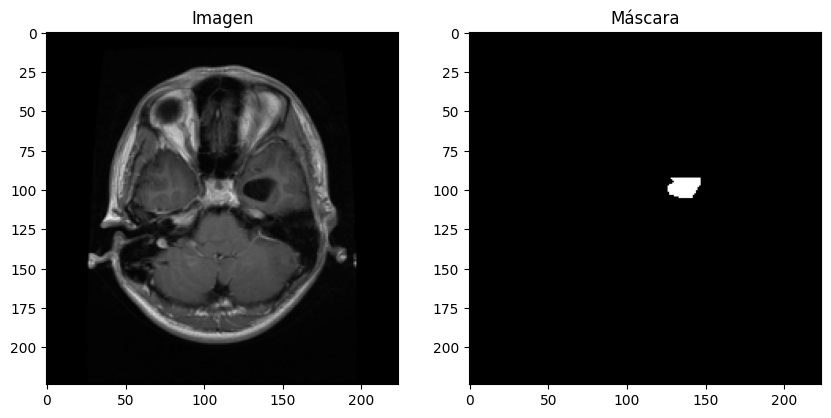

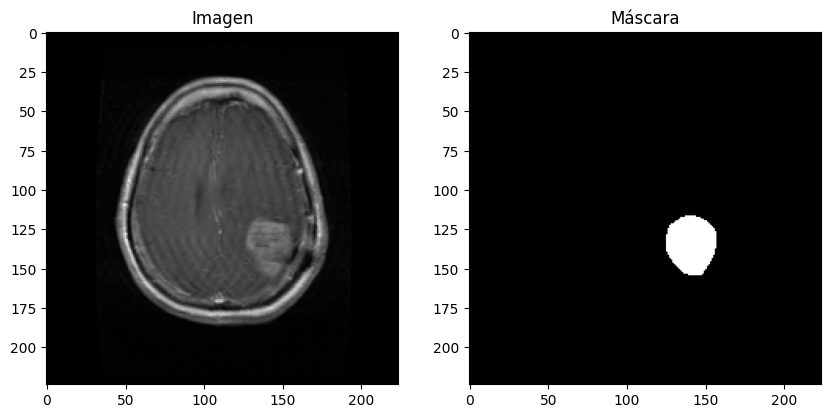

In [6]:
print("BTDataset")
BTdataset.display_images_masks(3)
BTdataset.display_images_masks(10)
BTdataset.display_images_masks(700)

Defino el tamaño para cada conjunto: entrenamiento, validación y prueba.
- 80% para entrenamiento
- 10% para prueba
- 10% para validación

Además defino los dataloaders para cada conjunto

In [7]:

# DEFINO TAMAÑOS DE CONJUNTOS DE ENTRENAMIENTO, VALIDACION Y PRUEBA
train_size = int(0.8 * len(BTdataset))  # 80% para entrenamiento
valid_size = int(0.1 * len(BTdataset))  # 10% para validación
test_size = len(BTdataset) - train_size - valid_size  # 10% para prueba

train_dataset, valid_dataset, test_dataset = random_split(BTdataset, [train_size, valid_size, test_size])

print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de validación:", len(valid_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))

# DEFINO DATALOADERS

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)


Tamaño del conjunto de entrenamiento: 2451
Tamaño del conjunto de validación: 306
Tamaño del conjunto de prueba: 307


In [8]:
print(train_dataset)

In [9]:
# VERIFICO LA FORMA DE LOS TENSORES DE CADA DATASET

# Verifico la forma de los tensores del train_datatset
print(BTdataset[0][0].shape)
print(BTdataset[0][1].shape)

# Probar la iteración sobre los DataLoader
for i, (image, mask) in enumerate(train_dataloader):
    print(f"Batch {i+1} (train):")
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)
    break  # Verifico sobre el primer batch
  # (batch_size, 1, 512, 512)

for i, (image, mask) in enumerate(valid_dataloader):
    print(f"Batch {i+1} (valid):")
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)
    break  # Verifico sobre el primer batch

for i, (image, mask) in enumerate(test_dataloader):
    print(f"Batch {i+1} (test):")
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)
    break  # Verifico sobre el primer batch



torch.Size([3, 224, 224])
torch.Size([1, 224, 224])
Batch 1 (train):
Image shape: torch.Size([16, 3, 224, 224])
Mask shape: torch.Size([16, 1, 224, 224])
Batch 1 (valid):
Image shape: torch.Size([16, 3, 224, 224])
Mask shape: torch.Size([16, 1, 224, 224])
Batch 1 (test):
Image shape: torch.Size([16, 3, 224, 224])
Mask shape: torch.Size([16, 1, 224, 224])


# MODELOS PRE-ENTRENADOS

Los dos siguientes modelos pre-entrenados son FCN ResNet-50 y FCN ResNet-101, Estos han sido entrenados con un subset del dataset COCO, con 21 clases (20 clases distintas + 1 clase de fondo).
DATASET:
https://cocodataset.org/#home

**Modelo FCN ResNet50 de torchvision:**

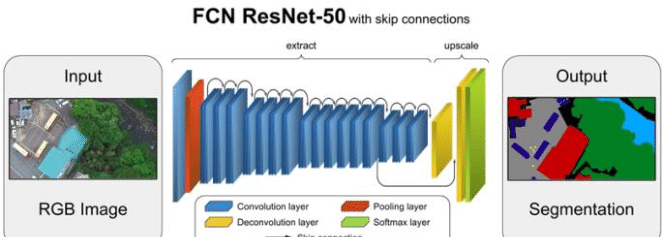

Fue entrenado con un batch size de 16.
Ajusto la última capa del modelo para que tenga dos canales de salida en vez de 21. Modifico la capa final de clasificación.



In [10]:
model_1 = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
print(model_1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 113MB/s]


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [11]:
# MODIFICO MODELO
model_1.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
model_1.aux_classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))

print(model_1)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

**Modelo FCN ResNet101 de torchvision:**

In [12]:
model_2 = torchvision.models.segmentation.fcn_resnet101(pretrained=True)
print(model_2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:01<00:00, 141MB/s]


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [13]:
# MODIFICO MODELO
model_2.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
model_2.aux_classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))

print(model_2)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

**Modelo DeepLabV3:**

El modelo Deeplabv3-MobileNetV3-Large se construye utilizando un modelo Deeplabv3 con el backbone MobileNetV3 grande. Ha sido entrenado en un subconjunto de COCO train2017, específicamente en las 20 categorías presentes en el conjunto de datos Pascal VOC.

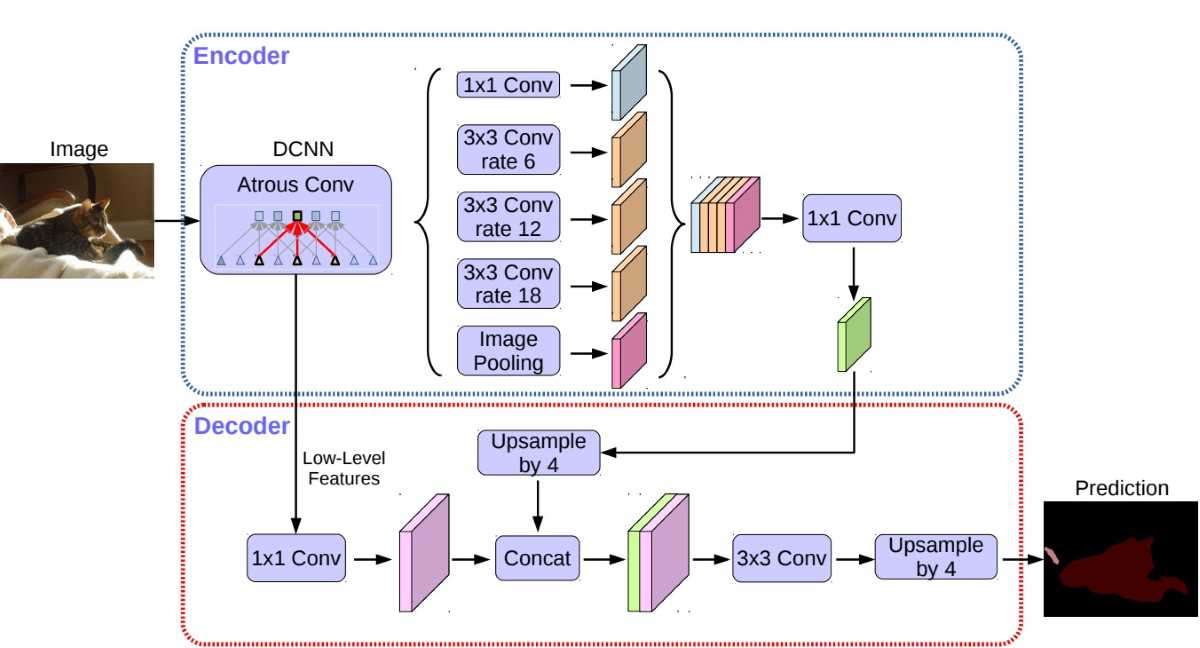

In [14]:
model_3 = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True)
print(model_3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 160MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [15]:
# MODIFICO MODELO
model_3.classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
model_3.aux_classifier[4] = nn.Conv2d(10, 2, kernel_size=(1, 1), stride=(1, 1))
print(model_3)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

# Entrenamiento

En el entrenamiento de los 3 modelos, utilizo primero CrossEntropyLoss() y después Focal Loss.
De esto, resultan en total 6 modelos, para los cuales analizo la evolución de la pérdida en el entrenamiento.
Los modelos entonces son:
- MODELO 1 --> **Modelo FCN ResNet50 de torchvision**
- MODELO 2--> **Modelo FCN ResNet101 de torchvision**
- MODELO 3 --> **Modelo DeepLabV3**

Todos los modelos fueron entrenados por 10 epochs.

In [16]:
criterion_CEL = torch.nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# ENTRENAMIENTO
def train_model(model, train_loader, optimizer, epochs, criterion, use_focal_loss = False):
  model.train()
  train_loss = 0
  modelo_losses = []
  for epoch in range(epochs):
    train_loss = 0
    for images, masks in train_loader:
      images = images.to(device)
      masks = masks.to(device)
      optimizer.zero_grad()
      outputs = model(images)['out']
      masks = masks.squeeze(1).long()
      if use_focal_loss:
                # Usar sigmoid_focal_loss si está seleccionado
        background_mask = masks == 0
        tumor_mask = masks == 1
        masks = torch.stack([background_mask, tumor_mask], dim=1).float()
        loss_value = torchvision.ops.sigmoid_focal_loss(outputs, masks, alpha=0.25, gamma=2.0, reduction="mean")
      else:
                # Usar CrossEntropyLoss
        loss_value = criterion(outputs, masks)
      loss_value.backward()
      optimizer.step()
      train_loss += loss_value.item()
    avg_loss = train_loss / len(train_loader)
    modelo_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
      # Gráfico de la pérdida por época

  plt.figure(figsize=(10, 5))
  plt.plot(range(1, epochs + 1), modelo_losses, marker='o', linestyle='-', color='b', label='Train Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training Loss over Epochs')  # Added a title
  plt.legend()
  plt.show()
  return model, modelo_losses

## Entrenando con Cross-Entropy Loss

## **MODELO 1**
(Modelo FCN ResNet50 de torchvision)

Epoch 1/10, Loss: 0.1644
Epoch 2/10, Loss: 0.0486
Epoch 3/10, Loss: 0.0280
Epoch 4/10, Loss: 0.0191
Epoch 5/10, Loss: 0.0146
Epoch 6/10, Loss: 0.0115
Epoch 7/10, Loss: 0.0096
Epoch 8/10, Loss: 0.0081
Epoch 9/10, Loss: 0.0072
Epoch 10/10, Loss: 0.0064


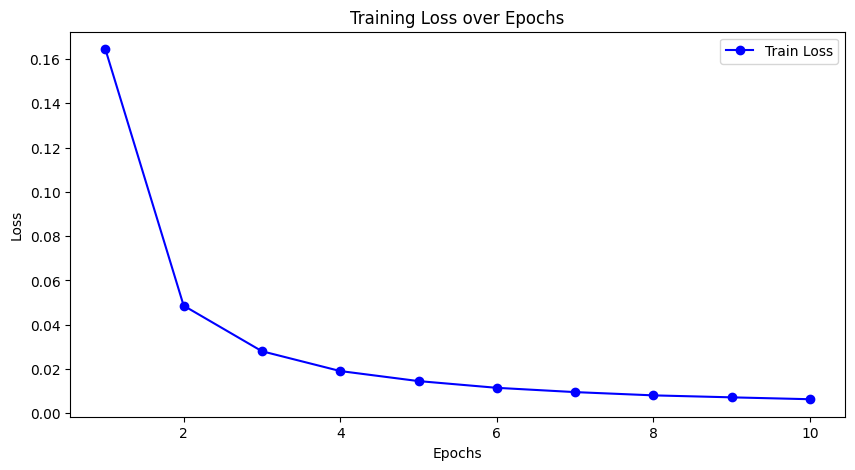

In [ ]:
model_1 = model_1.to(device)
for param in model_1.backbone.parameters():
  param.requires_grad = True
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.0001)

model_1_trained_losses =[]
model_1_trained, model_1_trained_losses = train_model(model_1, train_dataloader, optimizer, 10, criterion_CEL)


In [ ]:
from google.colab import drive
drive.mount('/content/RNP')  # Monta Google Drive en Colab

# Guardar el modelo en Google Drive
torch.save(model_1_trained.state_dict(), '/content/RNP/MyDrive/RNP/Modelos/brain_tumor_segmentation_model_1_trained.pth')


Drive already mounted at /content/RNP; to attempt to forcibly remount, call drive.mount("/content/RNP", force_remount=True).


## **MODELO 2**
(Modelo FCN ResNet101 de torchvision)

Epoch 1/10, Loss: 0.2138
Epoch 2/10, Loss: 0.0560
Epoch 3/10, Loss: 0.0303
Epoch 4/10, Loss: 0.0207
Epoch 5/10, Loss: 0.0146
Epoch 6/10, Loss: 0.0112
Epoch 7/10, Loss: 0.0093
Epoch 8/10, Loss: 0.0077
Epoch 9/10, Loss: 0.0066
Epoch 10/10, Loss: 0.0060


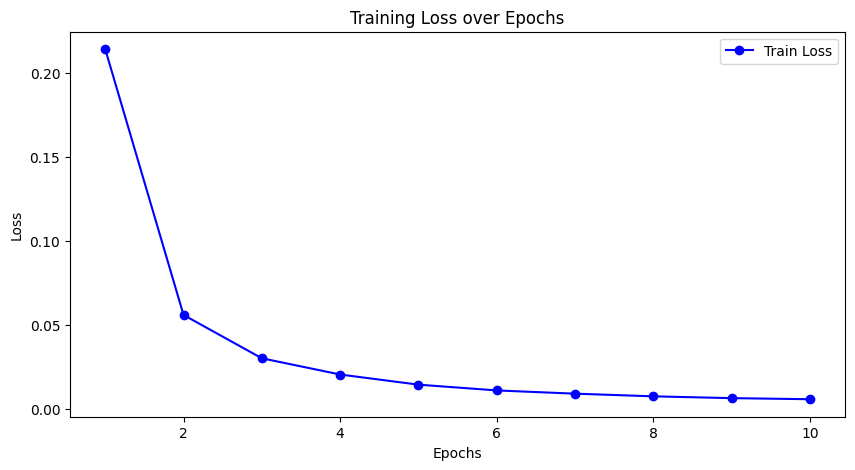

In [17]:
model_2 = model_2.to(device)
for param in model_2.backbone.parameters():
  param.requires_grad = True

optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0001)
model_2_trained_losses = []
model_2_trained, model_2_trained_losses = train_model(model_2, train_dataloader, optimizer, 10, criterion_CEL)

In [19]:
from google.colab import drive
drive.mount('/content/RNP')  # Monta Google Drive en Colab

# Guardar el modelo en Google Drive
torch.save(model_2_trained.state_dict(), '/content/RNP/MyDrive/RNP/Modelos/brain_tumor_segmentation_model_2_trained.pth')


Mounted at /content/RNP


## **MODELO 3**
(Modelo DeepLabV3)

Epoch 1/10, Loss: 0.1711
Epoch 2/10, Loss: 0.0469
Epoch 3/10, Loss: 0.0319
Epoch 4/10, Loss: 0.0262
Epoch 5/10, Loss: 0.0223
Epoch 6/10, Loss: 0.0195
Epoch 7/10, Loss: 0.0178
Epoch 8/10, Loss: 0.0163
Epoch 9/10, Loss: 0.0149
Epoch 10/10, Loss: 0.0139


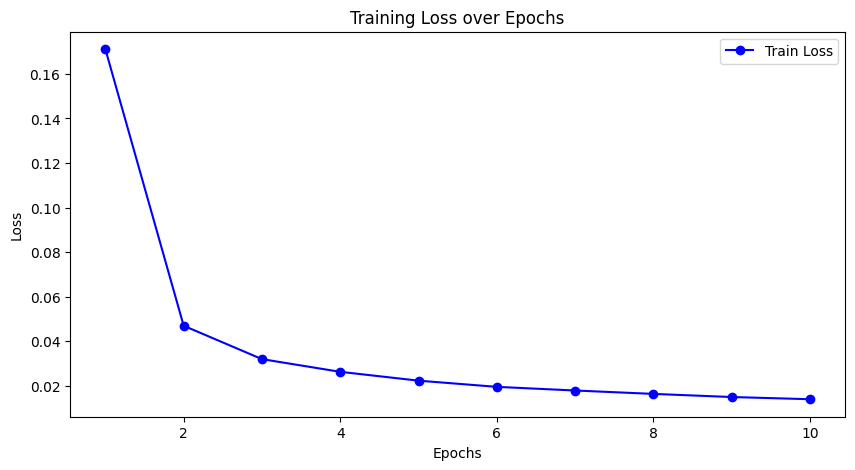

In [ ]:
model_3 = model_3.to(device)
for param in model_3.backbone.parameters():
  param.requires_grad = True

optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)
model_3_trained_losses = []
model_3_trained, model_3_trained_losses = train_model(model_3, train_dataloader, optimizer, 10, criterion_CEL)

In [ ]:
from google.colab import drive
drive.mount('/content/RNP')  # Monta Google Drive en Colab

# Guardar el modelo en Google Drive
torch.save(model_3_trained.state_dict(), '/content/RNP/MyDrive/RNP/Modelos/brain_tumor_segmentation_model_3_trained.pth')


Drive already mounted at /content/RNP; to attempt to forcibly remount, call drive.mount("/content/RNP", force_remount=True).


## Entrenando con Focal Loss

## MODELO 1
(Modelo FCN ResNet50 de torchvision)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.0179
Epoch 2/10, Loss: 0.0046
Epoch 3/10, Loss: 0.0027
Epoch 4/10, Loss: 0.0019
Epoch 5/10, Loss: 0.0014
Epoch 6/10, Loss: 0.0012
Epoch 7/10, Loss: 0.0010
Epoch 8/10, Loss: 0.0009
Epoch 9/10, Loss: 0.0008
Epoch 10/10, Loss: 0.0007


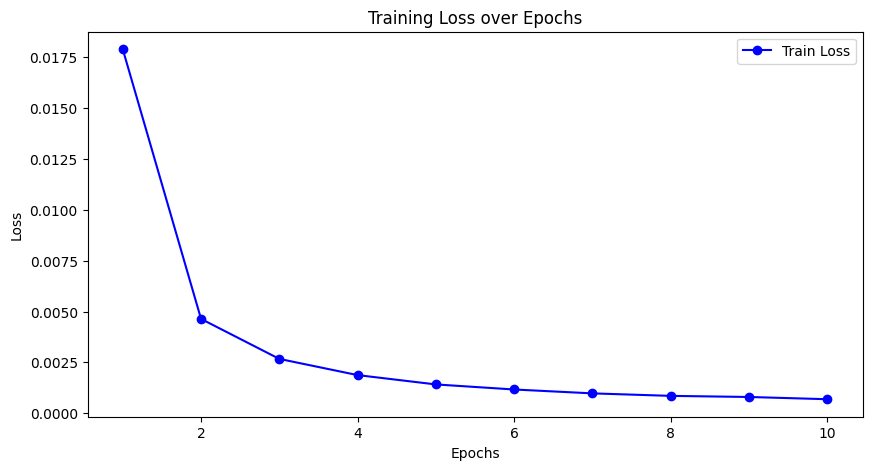

In [ ]:
model_1_for_FL = torchvision.models.segmentation.fcn_resnet50(pretrained=True)# MODIFICO MODELO
model_1_for_FL.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
model_1_for_FL.aux_classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
model_1_for_FL = model_1_for_FL.to(device)
for param in model_1_for_FL.backbone.parameters():
  param.requires_grad = True
optimizer = torch.optim.Adam(model_1_for_FL.parameters(), lr=0.0001)

model_1_focal_losses = []
modelo_1_focal, model_1_focal_losses = train_model(model_1_for_FL, train_dataloader, optimizer, 10, criterion_CEL, use_focal_loss=True)


In [ ]:
from google.colab import drive
drive.mount('/content/RNP')  # Monta Google Drive en Colab

# Guardar el modelo en Google Drive
torch.save(modelo_1_focal.state_dict(), '/content/RNP/MyDrive/RNP/Modelos/brain_tumor_segmentation_model_1_focal.pth')


Drive already mounted at /content/RNP; to attempt to forcibly remount, call drive.mount("/content/RNP", force_remount=True).


## MODELO 2
(Modelo FCN ResNet101 de torchvision)

Epoch 1/10, Loss: 0.0207
Epoch 2/10, Loss: 0.0052
Epoch 3/10, Loss: 0.0028
Epoch 4/10, Loss: 0.0019
Epoch 5/10, Loss: 0.0014
Epoch 6/10, Loss: 0.0011
Epoch 7/10, Loss: 0.0009
Epoch 8/10, Loss: 0.0008
Epoch 9/10, Loss: 0.0008
Epoch 10/10, Loss: 0.0006


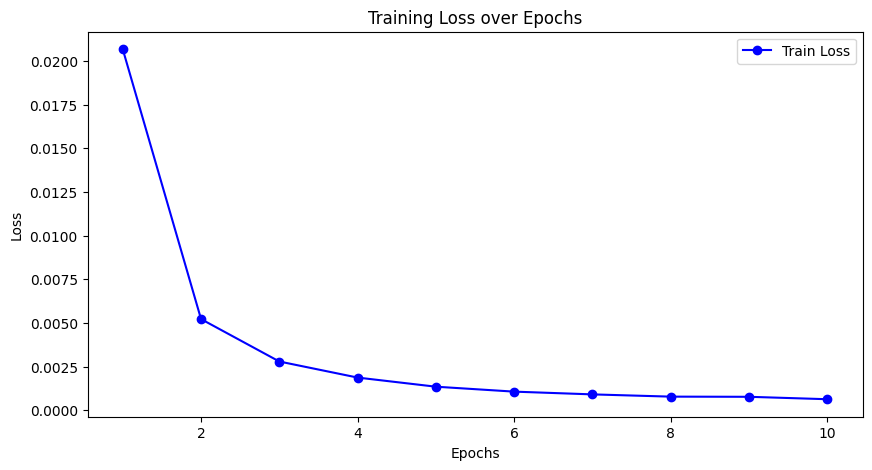

In [ ]:
model_2_for_FL = torchvision.models.segmentation.fcn_resnet101(pretrained=True)# MODIFICO MODELO
model_2_for_FL.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
model_2_for_FL.aux_classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
model_2_for_FL = model_2_for_FL.to(device)
for param in model_2_for_FL.backbone.parameters():
  param.requires_grad = True
optimizer = torch.optim.Adam(model_2_for_FL.parameters(), lr=0.0001)
model_2_focal_losses = []
model_2_focal, model_2_focal_losses = train_model(model_2_for_FL, train_dataloader, optimizer, 10, criterion_CEL, use_focal_loss=True)

In [ ]:
from google.colab import drive
drive.mount('/content/RNP')  # Monta Google Drive en Colab
torch.save(model_2_focal.state_dict(), '/content/RNP/MyDrive/RNP/Modelos/brain_tumor_segmentation_model_2_focal.pth')

Drive already mounted at /content/RNP; to attempt to forcibly remount, call drive.mount("/content/RNP", force_remount=True).


## MODELO 3
(Modelo DeepLabV3)

Epoch 1/10, Loss: 0.0406
Epoch 2/10, Loss: 0.0076
Epoch 3/10, Loss: 0.0049
Epoch 4/10, Loss: 0.0039
Epoch 5/10, Loss: 0.0032
Epoch 6/10, Loss: 0.0029
Epoch 7/10, Loss: 0.0026
Epoch 8/10, Loss: 0.0024
Epoch 9/10, Loss: 0.0022
Epoch 10/10, Loss: 0.0020


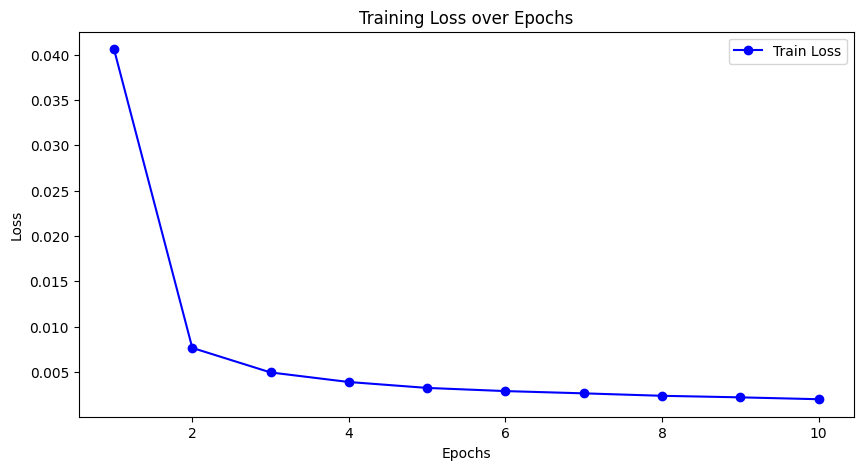

In [ ]:
model_3_for_FL = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True)
# MODIFICO MODELO
model_3_for_FL.classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
model_3_for_FL.aux_classifier[4] = nn.Conv2d(10, 2, kernel_size=(1, 1), stride=(1, 1))
model_3_for_FL = model_3_for_FL.to(device)
for param in model_3_for_FL.backbone.parameters():
  param.requires_grad = True
optimizer = torch.optim.Adam(model_3_for_FL.parameters(), lr=0.0001)
model_3_focal_losses = []
model_3_focal, model_3_focal_losses = train_model(model_3_for_FL, train_dataloader, optimizer, 10, criterion_CEL, use_focal_loss=True)

In [ ]:
drive.mount('/content/RNP')  # Monta Google Drive en Colab
torch.save(model_3_focal.state_dict(), '/content/RNP/MyDrive/RNP/Modelos/brain_tumor_segmentation_model_3_focal.pth')

Drive already mounted at /content/RNP; to attempt to forcibly remount, call drive.mount("/content/RNP", force_remount=True).


# Elección del mejor modelo

En primer lugar evalúo el rendimiento de cada modelo con el conjunto de testeo.

In [ ]:
!pip install torchmetrics
from torchmetrics import JaccardIndex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 17.7 MB/s eta 0:00:00


Defino una función que evalúa el rendimiento de cada modelo en un conjunto de datos de prueba utilizando el Jaccard Index (también conocido como IoU, Intersection over Union) como métrica. Esta métrica mide qué tan bien las predicciones del modelo coinciden con las máscaras reales del conjunto de datos.

In [ ]:
def test_model_JaccardIndex(model, test_loader, device='cuda'):
  model.eval()
  iou_metric = JaccardIndex(task="binary", num_classes=2).to(device)
  batches_iou = []  # Lista para acumular IoU de cada batch
  with torch.no_grad():
    for images, masks in test_loader:
      images = images.to(device)

      background_mask = (masks == 0).squeeze(1)  # Clase 0: fondo, (batch_size, height, width).
      tumor_mask = (masks == 1).squeeze(1)       # Clase 1: tumor,
      masks_one_hot = torch.stack([background_mask, tumor_mask], dim=1).float().to(device)
      #(batch_size, 2, height, width).
      outputs = model(images)['out']
      preds = torch.sigmoid(outputs)
      preds = (preds > 0.5).float()   # Binarizar las predicciones

      iou = iou_metric(preds, masks_one_hot)
      batches_iou.append(iou.item())  # Agregar IoU de este batch a la lista
  avg_iou = sum(batches_iou) / len(batches_iou)
  print(f'Test IoU: {avg_iou:.4f}')
  return avg_iou

Defino también una función para mostrar la predicción de los modelos para algunas imágenes del conjunto.

In [ ]:

def display_prediction(model, dataset, index, device='cuda'):
  model.eval()
  image, mask = dataset[index]
  image = image.unsqueeze(0).to(device)  # Add batch dimension

  # Prediccion
  with torch.no_grad():
    output = model(image)['out']
    pred = torch.sigmoid(output)
    pred = (pred[:, 1, :, :] > 0.5).float()  # Seleccionar el canal de tumor

  image = image.cpu().squeeze(0)
  mask = mask.cpu().squeeze(0)
  pred = pred.cpu().squeeze(0).squeeze(0) # remove batch and channel

  # Display the images
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].imshow(image.permute(1, 2, 0))  # Image
  axs[0].set_title('Image')
  axs[1].imshow(mask, cmap='gray')  # Ground truth mask
  axs[1].set_title('Ground Truth Mask')
  axs[2].imshow(pred, cmap='gray')  # Model prediction
  axs[2].set_title('Model Prediction')
  plt.show()

# Modelos entrenados con  Cross-Entropy Loss
Descargo los modelos ya entrenados guardados en Drive

In [ ]:
from google.colab import drive
drive.mount('/content/RNP')  # Monta Google Drive en Colab

Mounted at /content/RNP


## **MODELO 1**
(Modelo FCN ResNet50 de torchvision)

In [ ]:
# DESCARGO DE DRIVE LOS MODELOS
# Defino la arquitectura del modelo
model_1_downloaded = torchvision.models.segmentation.fcn_resnet50(weights=None, num_classes=2, aux_loss=True)

# Cargar el estado guardado en el modelo
model_1_downloaded.load_state_dict(torch.load('/content/RNP/MyDrive/RNP/Modelos/brain_tumor_segmentation_model_1_trained.pth'))

# Mover el modelo a la GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_1_downloaded = model_1_downloaded.to(device)


<ipython-input-21-11cc30f15cee>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1_downloaded.load_state_dict(torch.load('/content/RNP/MyDrive/RNP/Modelos/brain_tumor_

## **MODELO 2**
(Modelo FCN ResNet101 de torchvision)

In [ ]:
model_2_downloaded = torchvision.models.segmentation.fcn_resnet101(weights=None, num_classes=2, aux_loss=True)
model_2_downloaded.load_state_dict(torch.load('/content/RNP/MyDrive/RNP/Modelos/brain_tumor_segmentation_model_2_trained.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_2_downloaded = model_2_downloaded.to(device)

<ipython-input-22-061f523728ae>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_2_downloaded.load_state_dict(torch.load('/content/RNP/MyDrive/RNP/Modelos/brain_tumor_

## **MODELO 3**
(Modelo DeepLabV3)

In [ ]:
model_3_downloaded = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=None, num_classes=2, aux_loss=True)
model_3_downloaded.load_state_dict(torch.load('/content/RNP/MyDrive/RNP/Modelos/brain_tumor_segmentation_model_3_trained.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_3_downloaded = model_3_downloaded.to(device)

<ipython-input-23-48e11b930605>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_3_downloaded.load_state_dict(torch.load('/content/RNP/MyDrive/RNP/Modelos/brain_tumor_

# Modelos entrenados con FL
Descargo los modelos ya entrenados guardados en Drive

## **MODELO 1**
(Modelo FCN ResNet50 de torchvision)

In [ ]:
modelo_1_downloaded_fl = torchvision.models.segmentation.fcn_resnet50(weights=None, num_classes=2, aux_loss=True)
modelo_1_downloaded_fl.load_state_dict(torch.load('/content/RNP/MyDrive/RNP/Modelos/brain_tumor_segmentation_model_1_focal.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo_1_downloaded_fl = modelo_1_downloaded_fl.to(device)

<ipython-input-24-72cb35546895>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo_1_downloaded_fl.load_state_dict(torch.load('/content/RNP/MyDrive/RNP/Modelos/brain_tu

## **MODELO 2**
(Modelo FCN ResNet101 de torchvision)

In [ ]:
modelo_2_downloaded_fl = torchvision.models.segmentation.fcn_resnet101(weights=None, num_classes=2, aux_loss=True)
modelo_2_downloaded_fl.load_state_dict(torch.load('/content/RNP/MyDrive/RNP/Modelos/brain_tumor_segmentation_model_2_focal.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo_2_downloaded_fl = modelo_2_downloaded_fl.to(device)

<ipython-input-25-cbeb575bb497>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo_2_downloaded_fl.load_state_dict(torch.load('/content/RNP/MyDrive/RNP/Modelos/brain_tu

## **MODELO 3**
(Modelo DeepLabV3)

In [ ]:
modelo_3_downloaded = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=None, num_classes=2, aux_loss=True)
modelo_3_downloaded.load_state_dict(torch.load('/content/RNP/MyDrive/RNP/Modelos/brain_tumor_segmentation_model_3_focal.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo_3_downloaded = modelo_3_downloaded.to(device)

<ipython-input-26-d23990a408aa>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo_3_downloaded.load_state_dict(torch.load('/content/RNP/MyDrive/RNP/Modelos/brain_tumor

In [ ]:
print('Testeo del modelo 1 con CE')
test_model_JaccardIndex(model_1_downloaded, test_dataloader)
print('Testeo del modelo 2 con CE')
test_model_JaccardIndex(model_2_downloaded, test_dataloader)
print('Testeo del modelo 3 con CE')
test_model_JaccardIndex(model_3_downloaded, test_dataloader)
print('Testeo del modelo 1 con FL')
test_model_JaccardIndex(modelo_1_downloaded_fl, test_dataloader)
print('Testeo del modelo 2 con FL')
test_model_JaccardIndex(modelo_2_downloaded_fl, test_dataloader)
print('Testeo del modelo 3 con FL')
test_model_JaccardIndex(modelo_3_downloaded, test_dataloader)

Testeo del modelo 1 con CE
Test IoU: 0.9950
Testeo del modelo 2 con CE
Test IoU: 0.9961
Testeo del modelo 3 con CE
Test IoU: 0.9901
Testeo del modelo 1 con FL
Test IoU: 0.9941
Testeo del modelo 2 con FL
Test IoU: 0.9946
Testeo del modelo 3 con FL
Test IoU: 0.9779


0.9778712838888168

PREDICCION IMAGEN 3
PREDICCION MODELO 1 CON CE


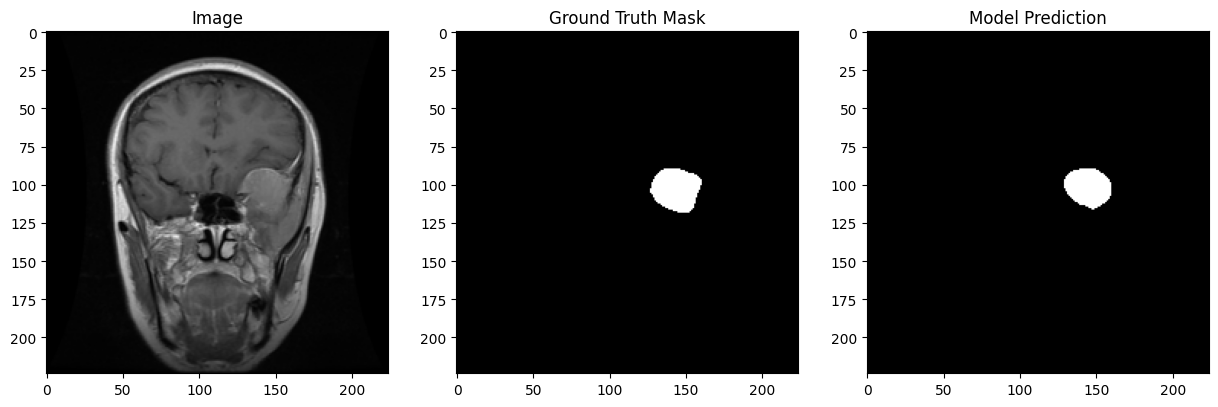

PREDICCION MODELO 2 CON CE


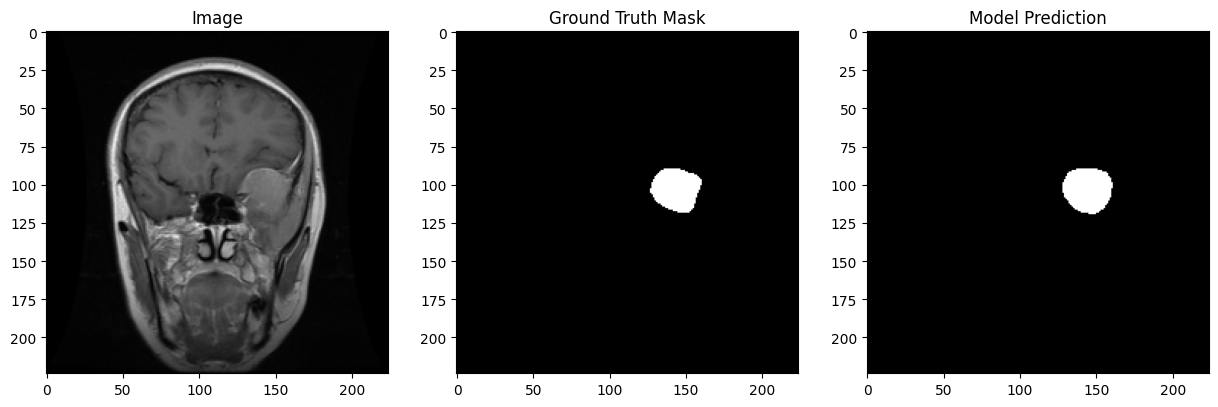

PREDICCION MODELO 3 CON CE


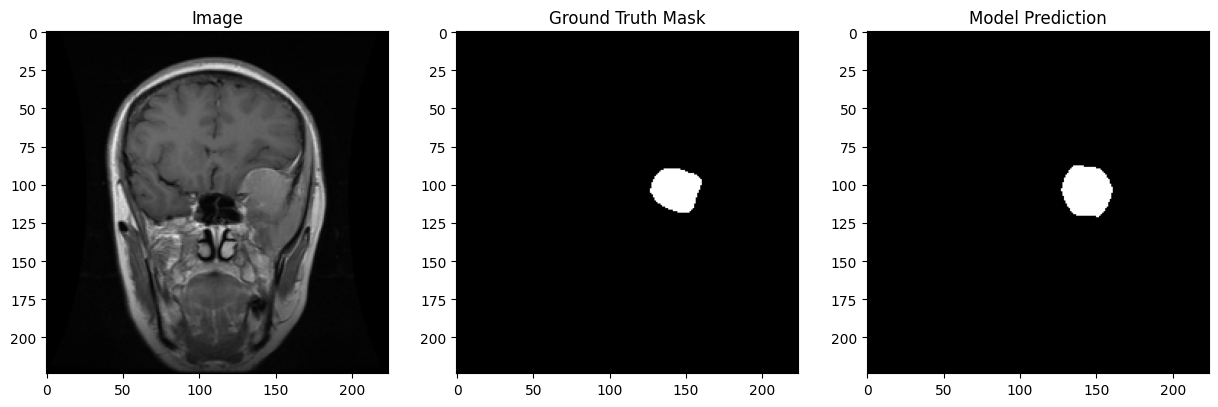

PREDICCION MODELO 1 CON FL


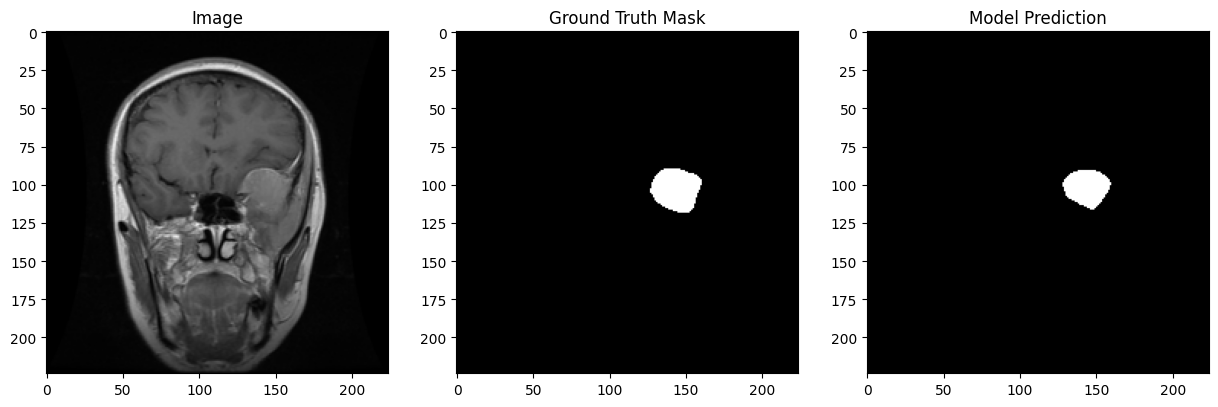

PREDICCION MODELO 2 CON FL


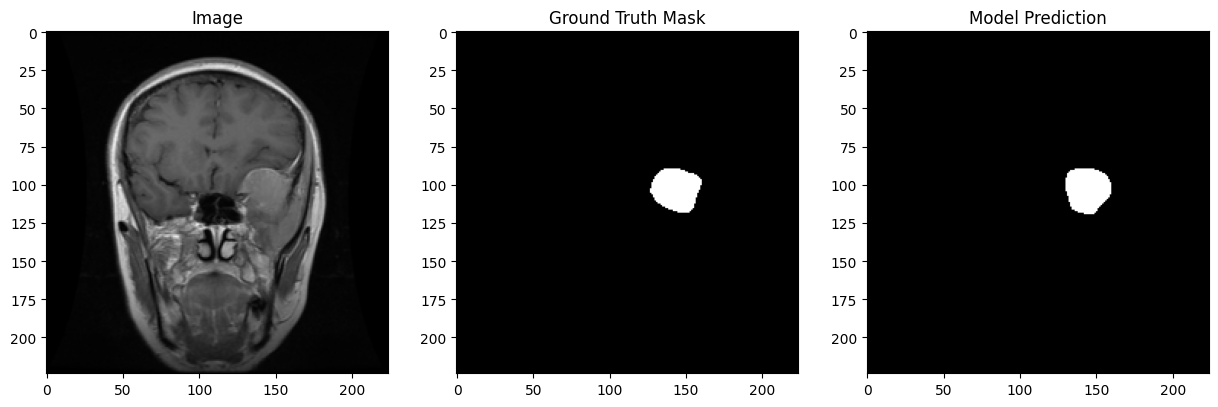

PREDICCION MODELO 3 CON FL


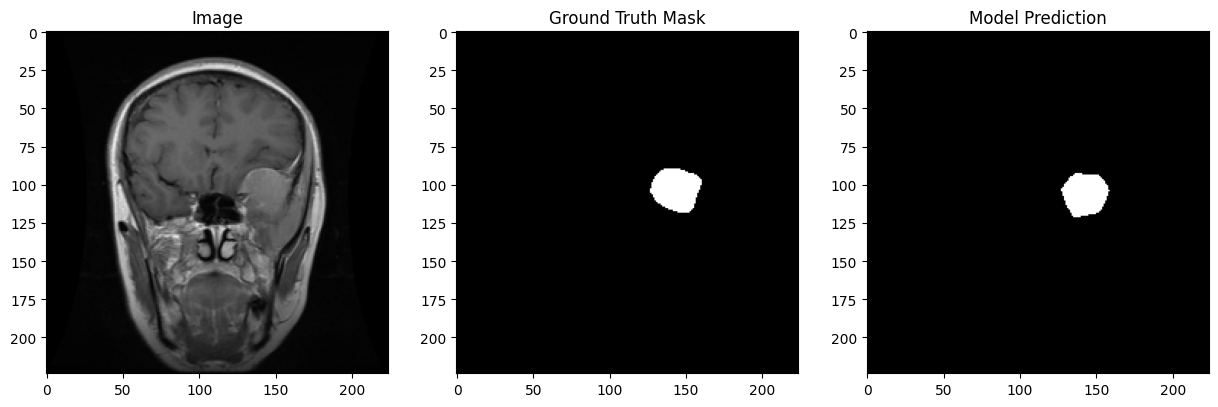

PREDICCION IMAGEN 200
PREDICCION MODELO 1 CON CE


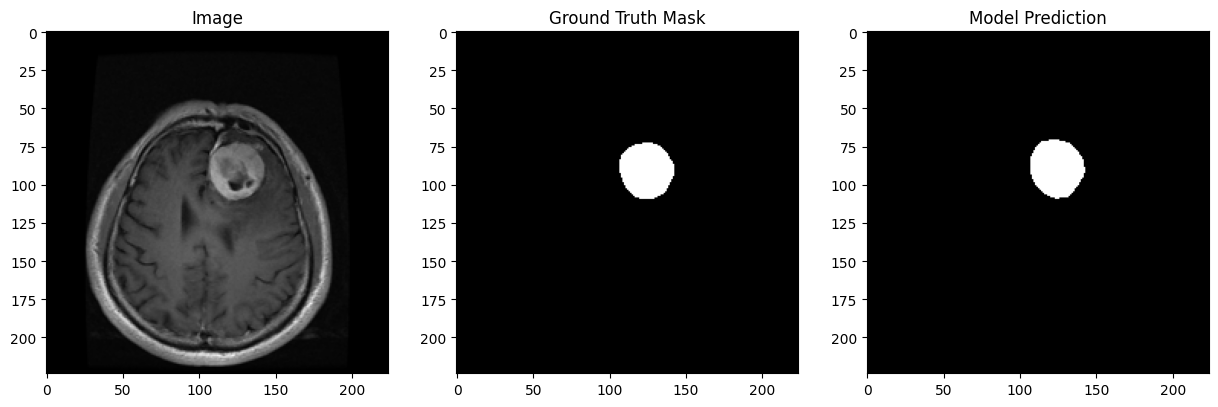

PREDICCION MODELO 2 CON CE


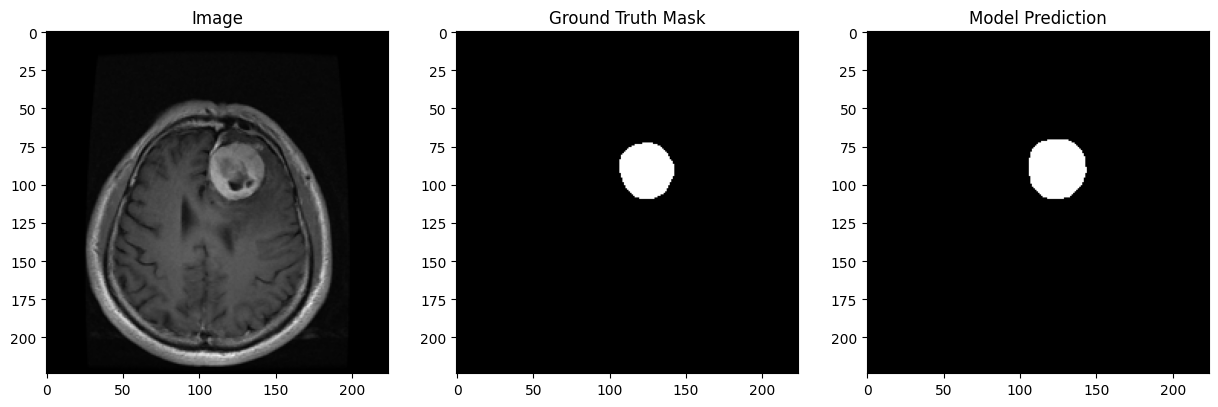

PREDICCION MODELO 3 CON CE


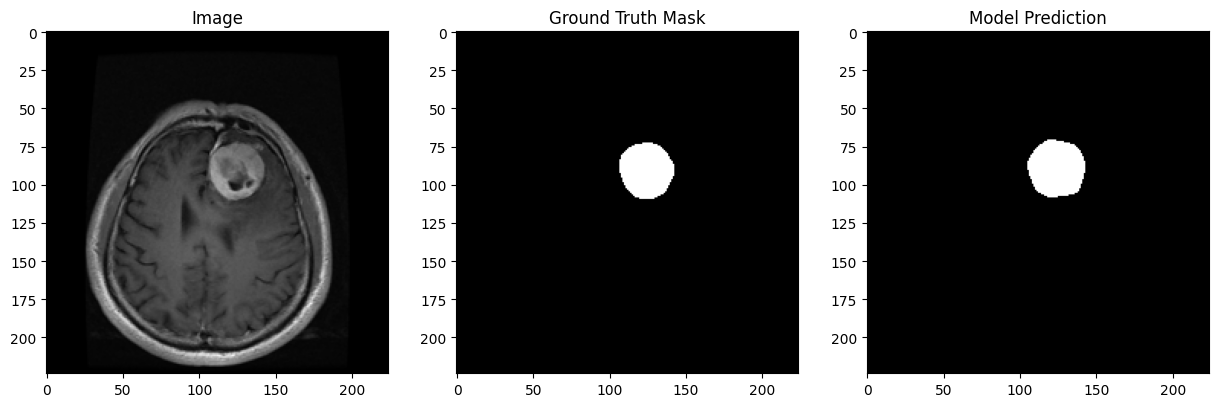

PREDICCION MODELO 1 CON FL


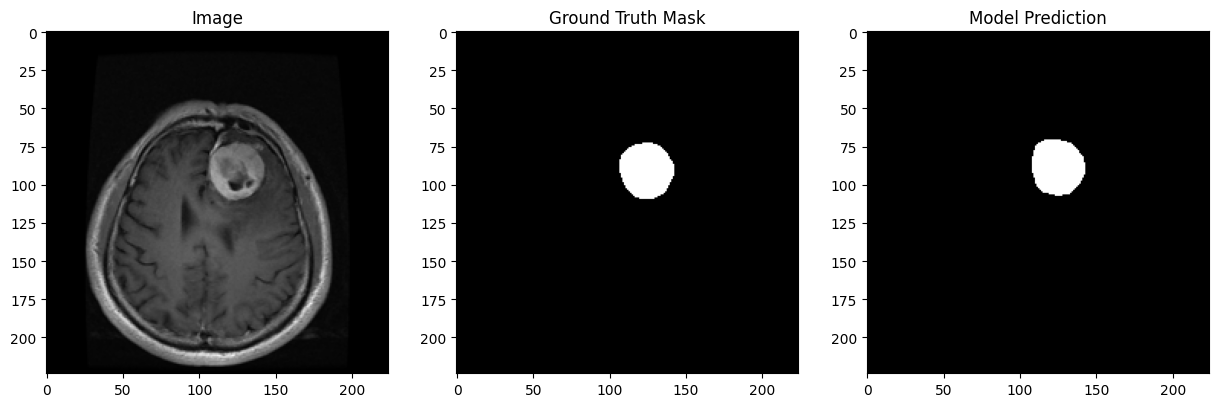

PREDICCION MODELO 2 CON FL


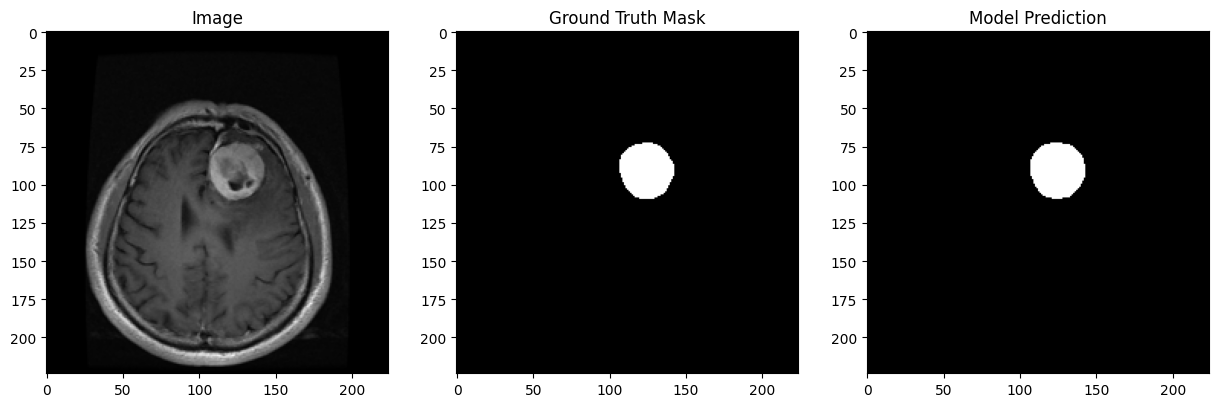

PREDICCION MODELO 3 CON FL


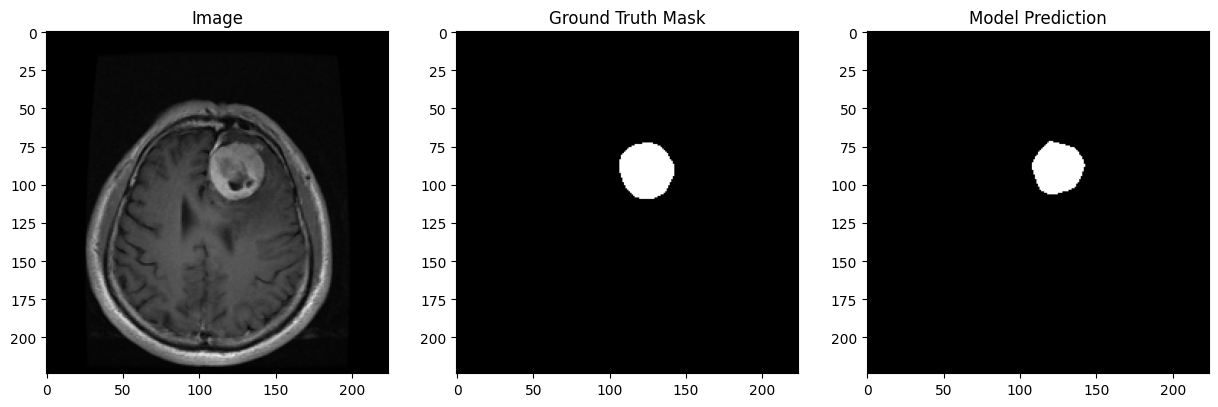

In [ ]:
print("PREDICCION IMAGEN 3")
print("PREDICCION MODELO 1 CON CE")
display_prediction(model_1_downloaded, test_dataset, 3)
print("PREDICCION MODELO 2 CON CE")
display_prediction(model_2_downloaded, test_dataset, 3)
print("PREDICCION MODELO 3 CON CE")
display_prediction(model_3_downloaded, test_dataset, 3)
print("PREDICCION MODELO 1 CON FL")
display_prediction(modelo_1_downloaded_fl, test_dataset, 3)
print("PREDICCION MODELO 2 CON FL")
display_prediction(modelo_2_downloaded_fl, test_dataset, 3)
print("PREDICCION MODELO 3 CON FL")
display_prediction(modelo_3_downloaded, test_dataset, 3)

print("PREDICCION IMAGEN 200")
print("PREDICCION MODELO 1 CON CE")
display_prediction(model_1_downloaded, test_dataset, 200)
print("PREDICCION MODELO 2 CON CE")
display_prediction(model_2_downloaded, test_dataset, 200)
print("PREDICCION MODELO 3 CON CE")
display_prediction(model_3_downloaded, test_dataset, 200)
print("PREDICCION MODELO 1 CON FL")
display_prediction(modelo_1_downloaded_fl, test_dataset, 200)
print("PREDICCION MODELO 2 CON FL")
display_prediction(modelo_2_downloaded_fl, test_dataset, 200)
print("PREDICCION MODELO 3 CON FL")
display_prediction(modelo_3_downloaded, test_dataset, 200)



In [ ]:
from google.colab import drive
drive.mount('/content/RNP')  # Monta Google Drive en Colab
# Guardo imagenes de valid_dataset para despues pasarlas por el modelo mostrando la app
num_images = 5
for i in range(num_images):
    image, mask = valid_dataset[i]
    torchvision.utils.save_image(image, f'/content/RNP/MyDrive/RNP/Imagenes/image_{i}.png')
    mask = mask.to(dtype=torch.float32)
    if mask.max() > 1:
        mask = mask / mask.max()
    torchvision.utils.save_image(mask, f'/content/RNP/MyDrive/RNP/Imagenes/mask_{i}.png')




Drive already mounted at /content/RNP; to attempt to forcibly remount, call drive.mount("/content/RNP", force_remount=True).


**El modelo elegido es el modelo 2 (Modelo FCN ResNet101 de torchvision) entrenado con Cross-Entropy Loss, ya que es el que tiene mayor IoU**:

Testeo del modelo 1 con CE --> Test IoU: 0.9950

Testeo del modelo 2 con CE --> Test IoU: 0.9961

Testeo del modelo 3 con CE --> Test IoU: 0.9901

Testeo del modelo 1 con FL --> Test IoU: 0.9941

Testeo del modelo 2 con FL --> Test IoU: 0.9946

Testeo del modelo 3 con FL --> Test IoU: 0.9779